In [1]:
import app 
import importlib
importlib.reload(app)


%load_ext autoreload
%autoreload 2

In [2]:
%load_ext dotenv
%dotenv

In [2]:
import os
from dotenv import load_dotenv

load_dotenv() 
ROOT = os.getenv("ROOT")
DATA = os.getenv("DATA")
SCRIPTS = os.getenv("SCRIPTS")

# Make root
os.chdir(SCRIPTS)
print(os.getcwd())

/home/callebalik/clinical_NLP_SE/scripts


In [3]:

from pathlib import Path
import pandas as pd
import re as re
import numpy as np

from metrics.conll2003_utills import create_total_target_vector, conll2003_to_df, get_cleaned_label
from metrics.confusion_matrix import generate_confusion_matrix

def create_total_target_df(dir_path):
    pathlist = Path(dir_path).glob("**/*.conll")

    frames = []
    doc = []
    
    for path in pathlist:
        frame = conll2003_to_df(path)
        doc.append(re.search(r"(\d)(?=.\w+)",path.name).group())
        frames.append(frame) 
    return pd.concat(frames, keys=doc) # This creates hierarchical index, e.g. a1.loc["3"] all rows for doc 3

a1 = create_total_target_df(Path(f"{DATA}/interim/corpus/a1"))
a2 = create_total_target_df(Path(f"{DATA}/interim/corpus/a2"))

# [get_cleaned_label(label) for label in df["NE"]]
# dict = {"a1":a1, "a2":a2}


df = pd.DataFrame()
c = ["TOKEN", "NE"]
df["TOKEN"] = a1["TOKEN"]

df.insert(1, "NE_a1", a1["NE"])
df.insert(2, "NE_a2", a2["NE"])

# Get all that does not contain DIS labels
df_sfno = (df[~df.NE_a1.str.contains("DIS") & ~df.NE_a2.str.contains("DIS")]) 

df_sfno["A1"] = [get_cleaned_label(label) for label in df_sfno["NE_a1"]]
df_sfno["A2"] = [get_cleaned_label(label) for label in df_sfno["NE_a2"]]

/tmp/ipykernel_958/95166337.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sfno["A1"] = [get_cleaned_label(label) for label in df_sfno["NE_a1"]]
/tmp/ipykernel_958/95166337.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sfno["A2"] = [get_cleaned_label(label) for label in df_sfno["NE_a2"]]


(array([[7.39130435e-01, 1.95652174e-01, 0.00000000e+00, 6.52173913e-02],
        [1.00671141e-01, 6.91275168e-01, 2.01342282e-02, 1.87919463e-01],
        [0.00000000e+00, 0.00000000e+00, 9.45945946e-01, 5.40540541e-02],
        [1.97921821e-03, 4.45324097e-03, 4.94804552e-04, 9.93072736e-01]]),
 <AxesSubplot:xlabel='annotator2', ylabel='annotator1'>,
 <module 'matplotlib.pyplot' from '/home/callebalik/.virtualenvs/venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>)

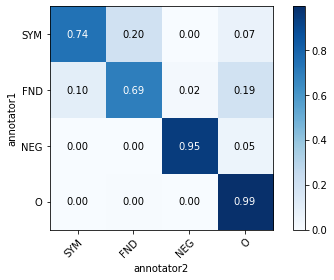

In [4]:
from plot_confusion_matrix import plot_confusion_matrix

classes = ["SYM","FND","NEG","O"]
title = None
plot_confusion_matrix(df_sfno["A1"], df_sfno["A2"], classes=classes, normalize=True, xlabel="annotator2", ylabel="annotator1", title=None)

In [6]:
# conditions = [
#     (df.NE_a1.str.contains("DIS") & (df.NE_a2.str.contains("SYM"))), # a1 overrules 
#     (df.NE_a1.str.contains("DIS") & (df.NE_a2.str.contains("FND"))), # a1 overrules
#     (df.NE_a1.str.contains("DIS") & (df.NE_a2.str.contains("NEG"))), # a1 overrules
#     ]
# values = ['DIS',"DIS","DIS"]
# df['NE'] = np.select(conditions, values)

values = ['SYM/FND', "NEG", "O"]

conditions = [
    (df_sfno.A1.str.contains("FND")) | (df_sfno.A1.str.contains("SYM")),
    (df_sfno.A1.str.contains("NEG")),
    (df_sfno.A1.str.contains("O"))
     ]

df_sfno['A1_sf'] = np.select(conditions, values)

conditions = [
    (df_sfno.A2.str.contains("FND")) | (df_sfno.A2.str.contains("SYM")), 
    (df_sfno.A2.str.contains("NEG")),
    (df_sfno.A2.str.contains("O"))
     ]

df_sfno['A2_sf'] = np.select(conditions, values)

df_sfno[df_sfno.A2_sf.str.contains("SYM")]

/tmp/ipykernel_958/1479298391.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sfno['A1_sf'] = np.select(conditions, values)
/tmp/ipykernel_958/1479298391.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sfno['A2_sf'] = np.select(conditions, values)


TOKEN  NE_a1  NE_a2   A1   A2    A1_sf    A2_sf
4 36         agiterat      O  I-FND    O  FND        O  SYM/FND
  47           kräkts  I-FND  I-SYM  FND  SYM  SYM/FND  SYM/FND
  51   svårkontaktbar  B-FND  B-SYM  FND  SYM  SYM/FND  SYM/FND
  96         takykard  B-FND  I-FND  FND  FND  SYM/FND  SYM/FND
  100        blåsljud  I-FND  B-FND  FND  FND  SYM/FND  SYM/FND
...               ...    ...    ...  ...  ...      ...      ...
2 193        blåmärke  B-FND  B-FND  FND  FND  SYM/FND  SYM/FND
  198    utåtrotation  I-FND  I-FND  FND  FND  SYM/FND  SYM/FND
  211          acidos  B-FND  B-FND  FND  FND  SYM/FND  SYM/FND
  239        blödning  I-FND  I-FND  FND  FND  SYM/FND  SYM/FND
  252          febril  B-FND  B-FND  FND  FND  SYM/FND  SYM/FND

[174 rows x 7 columns]

NameError: name 'x' is not defined

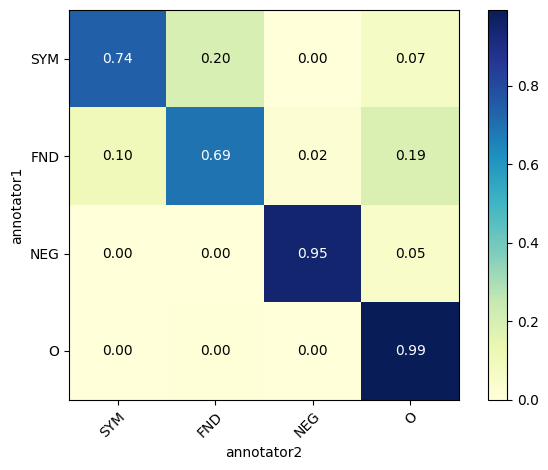

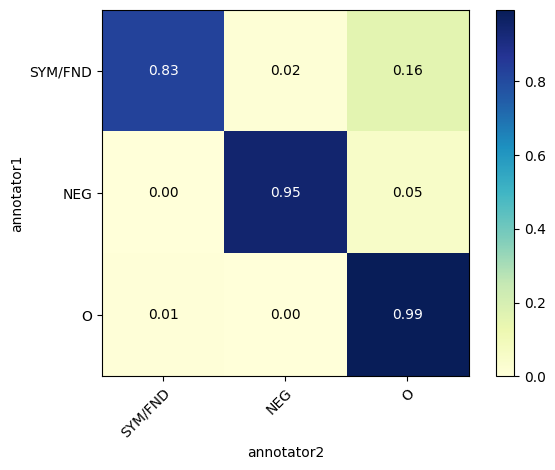

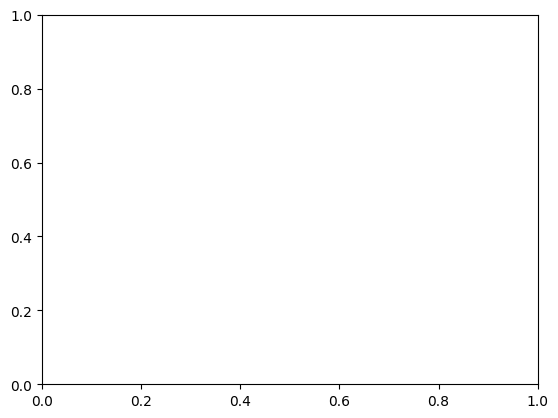

In [86]:
from plot_confusion_matrix import plot_confusion_matrix
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

viridisBig = cm.get_cmap('viridis_r', 512)
viridis_new = ListedColormap(viridisBig(np.linspace(0.15, 1, 256)))

viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 1])
newcolors[:5, :] = pink
newcmp = ListedColormap(newcolors)

coolw = cm.get_cmap('coolwarm', 512)
coolw_new = ListedColormap(coolw(np.linspace(0.15, 1, 256)))

color = coolw_new
color = plt.cm.YlGnBu
# color = plt.cm.coo

mpl.style.use("default")


classes1 = ["SYM", "FND","NEG","O"]
classes2 = ["SYM/FND","NEG","O"]


cm1, ax1, fig1 = plot_confusion_matrix(df_sfno.A1, df_sfno.A2, classes=classes1, normalize=True, xlabel="annotator2", ylabel="annotator1", cmap=color, title=None)
cm2, ax2, fig2 = plot_confusion_matrix(df_sfno.A1_sf, df_sfno.A2_sf, classes=classes2, normalize=True, xlabel="annotator2", ylabel="annotator1", cmap=color, title=None)

fig1, ax1 = plt.subplots()
# fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

ax.plot(x, y)
ax.set_title('A single plot')

# fig.colorbar(im1, ax=ax1)
# fig.colorbar(im2, ax=ax2)


plt.savefig(f"{DATA}/processed/IAA_SYM_FND", bbox_inches='tight')

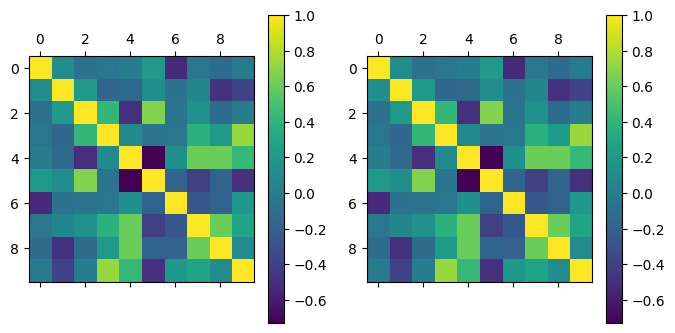

In [82]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

df = pd.DataFrame(np.random.rand(10, 10))

fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

ax1, ax2 = axes

im1 = ax1.matshow(df.corr())
im2 = ax2.matshow(df.corr())

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)

In [81]:
from matplotlib import pyplot
from matplotlib import cm

def corr_heatmaps(data1, data2, method='pearson'):

    # Basic Configuration
    fig, axes = plt.subplots(ncols=2, figsize=(12, 12))
    ax1, ax2 = axes
    corr_matrix1 = data1.corr(method=method)
    corr_matrix2 = data2.corr(method=method)
    columns1 = corr_matrix1.columns
    columns2 = corr_matrix2.columns

    # Heat maps.
    im1 = ax1.matshow(corr_matrix1, cmap='coolwarm')
    im2 = ax2.matshow(corr_matrix2, cmap='coolwarm')

    # Formatting for heat map 1.
    ax1.set_xticks(range(len(columns1)))
    ax1.set_yticks(range(len(columns1)))
    ax1.set_xticklabels(columns1)
    ax1.set_yticklabels(columns1)
    ax1.set_title(data1.name, y=-0.1)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
    plt.colorbar(im1, fraction=0.045, pad=0.05, ax=ax1)

    # Formatting for heat map 2.
    ax2.set_xticks(range(len(columns2)))
    ax2.set_yticks(range(len(columns2)))
    ax2.set_xticklabels(columns2)
    ax2.set_yticklabels(columns2)
    ax2.set_title(data2.name, y=-0.1)
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
    plt.colorbar(im2, fraction=0.045, pad=0.05, ax=ax2)

    fig.tight_layout()

In [98]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

import pandas as pd 

a1 = df_sfno["A1"]
a2 = df_sfno["A2"]


classes = ["SYM","FND","NEG","O"]
rows = ["precision","recall","f1-score"]
print(f"Cohen Kappa {cohen_kappa_score(a1, a2)}")
cr = classification_report(a1,a2, labels=classes, output_dict=True)
cr = pd.DataFrame.from_dict(cr)

report = cr.loc[rows,classes]
print(report.to_latex())
report

Cohen Kappa 0.8405168266477285
\begin{tabular}{lrrrr}
\toprule
{} &       SYM &       FND &       NEG &         O \\
\midrule
precision &  0.641509 &  0.851240 &  0.945946 &  0.982860 \\
recall    &  0.739130 &  0.691275 &  0.945946 &  0.993073 \\
f1-score  &  0.686869 &  0.762963 &  0.945946 &  0.987940 \\
\bottomrule
\end{tabular}



,SYM,FND,NEG,O
precision,0.641509,0.851240,0.945946,0.982860
recall,0.739130,0.691275,0.945946,0.993073
f1-score,0.686869,0.762963,0.945946,0.987940


In [13]:
from pathlib import Path
import pandas as pd

from metrics.conll2003_utills import create_total_target_vector
from metrics.confusion_matrix import generate_confusion_matrix

a1 = create_total_target_vector(Path(f"{DATA}/interim/corpus/a1"))
a2 = create_total_target_vector(Path(f"{DATA}/interim/corpus/a2"))

dict = {"a1":a1, "a2":a2}
df = pd.DataFrame(dict)


classes = ["SYM","FND","NEG","DIS","O"]
cm = generate_confusion_matrix(a1, a2, classes)

df

,a1,a2
0,O,O
1,O,O
2,DIS,SYM
3,O,O
4,O,O
...,...,...
2333,O,O
2334,O,O
2335,DIS,DIS
2336,O,O


In [21]:
from pathlib import Path
import spacy

from metrics.spacy_utills import create_total_prediction_vector
from metrics.spacy_utills import create_prediction_vector

corpus = Path(f"{DATA}/raw/corpus/curation")

nlp = spacy.load("sv_pipeline")

docs = []

pathlist = Path(corpus).glob("**/*.conll")

for path in pathlist:
    create_prediction_vector()

create_total_prediction_vector(nlp, docs)

/home/callebalik/clinical_NLP_SE/data


In [ ]:
def get_dataset_labels(annotation_set):
    return sorted(set(create_total_target_vector(annotation_set)))

In [ ]:
from plot_confusion_matrix import plot_confusion_matrix

classes = ["SYM","FND","NEG","DIS","O"]

plot_confusion_matrix(a1, a2, classes=classes, normalize=True, xlabel="annotator2", ylabel="annotator1")